##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.


In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [2]:
print(tf.__version__)

2.20.0


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb_v1')

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 61s 1us/step


In [4]:
os.listdir(dataset_dir)

['aclImdb']

In [5]:
train_dir = os.path.join(dataset_dir, 'aclImdb', 'train')
test_dir = os.path.join(dataset_dir, 'aclImdb', 'test')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [6]:
sample_file = os.path.join(train_dir, 'pos', '1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [7]:
# remove unsup folder to avoid using it by mistake
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set).

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [8]:
'''
Mỗi batch có tối đa 32 câu
Batch cuối có thể nhỏ hơn
Dataset trả về là (text_batch, label_batch)
'''
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
amount_batches = tf.data.experimental.cardinality(raw_train_ds)
print(f'Number of batches in the training dataset: {amount_batches}')

Number of batches in the training dataset: 625


✅ Tập train của bạn có 625 batch
⚠️ Mỗi batch có tối đa 32 câu, batch cuối có thể < 32

In [25]:
'''
Lấy 2 batch đầu tiên
Print kích thước của từng text_batch.
'''
for text_batch, label_batch in raw_train_ds.take(2):
  print("text_batch: ", text_batch.shape)
  print("=========================")
  print("label_batch: ", label_batch, label_batch.shape)

text_batch:  (32,)
label_batch:  tf.Tensor([1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1], shape=(32,), dtype=int32) (32,)
text_batch:  (32,)
label_batch:  tf.Tensor([1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1], shape=(32,), dtype=int32) (32,)


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [18]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(32):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b"The idea ia a very short film with a lot of information. Interesting, entertaining and leaves the viewer wanting more. The producer has produced a short film of excellent quality that cannot be compared to any other short film that I have seen. I have rated this film at the highest possible rating. I also recommend that it is shown to office managers and business people in any establishment. What comes out of it is the fact that people with ideas are never listened to, their voice is never heard. It is a lesson to be learned by any office that wants to go forward. I hope that the produced will produce a second part to this 'idea'. I look forward to viewing the sequence. Once again congrats to Halaqah media in producing a film of excellence and quality with a lesson in mind."
Label 1
Review b"When the Chamberlain family is camping near Ayers Rock, Australia, Lindy Chamberlain (Meryl Streep) sees her baby being dragged out of their tent by a dingo and then begins an ordeal that 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [20]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [21]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [22]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [30]:
num_batches = tf.data.experimental.cardinality(raw_train_ds).numpy()
print("raw_train_ds", num_batches)

num_batches = tf.data.experimental.cardinality(raw_val_ds).numpy()
print("raw_val_ds", num_batches)

num_batches = tf.data.experimental.cardinality(raw_test_ds).numpy()
print("raw_test_ds", num_batches)


raw_train_ds 625
raw_val_ds 157
raw_test_ds 782


### Thông tin tập train

- Dùng `tf.keras.utils.text_dataset_from_directory` với `batch_size=32`, `validation_split=0.2`, `subset='training'`, `seed=42`.

- Số mẫu train: 20,000 (80% của 25,000 review). Số batch: 625 (batch cuối có thể < 32).

- Mỗi phần tử của raw_train_ds là `(text_batch, label_batch)`:

  - `text_batch` có shape `(batch_size, )`, dtype `tf.string`, chứa nội dung review dạng chuỗi.

  - `label_batch` có shape `(batch_size, )`, dtype `tf.int32`, giá trị 0/1 tương ứng `class_names = ['neg', 'pos']`.

- Dữ liệu đã được shuffle (seed cố định) trước khi chia batch, nên `take(2)` sẽ lấy 2 batch đầu sau shuffle.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [26]:
def custom_standardization(input_data):
  '''
  # Dùng 2 regex vì xử lý 2 loại nhiễu khác nhau:
  # (1) '<br />' là HTML line-break → cần replace bằng space để tránh dính từ
  # (2) punctuation là nhiễu từ vựng → remove hoàn toàn; tách bước giúp giữ đúng ngữ nghĩa
  '''
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

1. TextVectorization hoạt động: nhận chuỗi, chuẩn hoá (standardize), tách token (split), chuyển mỗi token thành chỉ số nguyên (vocabulary), trả về chuỗi số hoặc vector hoá theo cấu hình.
2. max_tokens: số lượng token tối đa trong vocab; phần còn lại gán thành OOV.
Token → đơn vị văn bản sau chuẩn hóa/tách: thường là từ hoặc ký hiệu. Ví dụ câu “The movie was great!” chuẩn hóa thành “the movie was great”, tách ra các token: ["the", "movie", "was", "great"].
Chuyển mỗi token thành chỉ số nguyên (vocabulary) → bạn xây một bảng tra cứu (vocab) ánh xạ mỗi token phổ biến sang một số nguyên cố định. Ví dụ vocab: {"the":1, "movie":2, "was":3, "great":4, "<OOV>":0}. Câu trên thành dãy số: [1, 2, 3, 4].
max_tokens: Bạn lấy các token xuất hiện nhiều nhất đến ngưỡng này để gán chỉ số; các token hiếm vượt quá giới hạn sẽ không có chỉ số riêng.
Phần còn lại gán thành OOV (out-of-vocabulary) → mọi token không nằm trong vocab sẽ được thay bằng một nhãn/ID đặc biệt, thường là 0. Ví dụ nếu vocab chỉ có {"the":1, "movie":2} và gặp câu “The movie was superb”, thì “was”, “superb” không có trong vocab nên chuỗi số sẽ là [1, 2, 0, 0] (0 đại diện cho OOV).
3. output_sequence_length: ép mỗi chuỗi sau vector hóa về cùng độ dài L.
Nếu chuỗi ngắn hơn L → pad thêm 0 (ở cuối, mặc định) cho đủ L.
Nếu chuỗi dài hơn L → cắt bớt (ở cuối, mặc định) còn đúng L.
Ví dụ: output_sequence_length=5, vocab: the→1, movie→2, was→3, great→4, bad→5, <OOV>→0.
Câu “the movie was great” → [1,2,3,4] ngắn hơn 5 → pad: [1,2,3,4,0].
Câu “the movie was very very great” (giả sử “very” OOV→0) → [1,2,3,0,0,4] dài 6 → cắt đuôi còn [1,2,3,0,0].
Mục đích: tạo tensor cố định kích thước để đưa thẳng vào embedding/mô hình.

In [27]:
'''
# Chuẩn hoá và tokenize văn bản thành chuỗi số nguyên: giữ tối đa 10.000 tokens phổ biến nhất,
# Giả sử trong tập train có 15.000 tokens thì chỉ giữ lại 1000 token xuất hiện nhiều nhất
# Mỗi câu được pad/cắt thành 250 tokens để làm đầu vào cố định cho mô hình học sâu.chỉ lấy 250 tokens cuối.
'''
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

1. adapt() học thống kê từ dữ liệu train để xây vocab/lookup (đếm tần suất token, gán ID, thiết lập OOV…).
2. Nếu không adapt(), vocab trống → mọi token thành OOV hoặc lỗi shape, nên vectorize_layer(text) không dùng được.
3. Luôn adapt() trên tập train (không dùng test/val) và chỉ cần chạy một lần trước khi dùng layer cho map hoặc predict.

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
vectorize_layer.get_vocabulary()

Let's create a function to see the result of using this layer to preprocess some data.

In [33]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [34]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
print("Length of text batch: ", len(text_batch))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Length of text batch:  32
Review tf.Tensor(b"My children watch the show everyday that its on. Its a great program for younger children. However they need to stop showing re-runs and do some more actual shows and get rid of Rooney's and Deedee's YELLOW TEETH. Moe is the only Doodle bop with clean white pearlie teeth and the children notice these things and ask if the 2 don't ever brush their teeth? Does the show ever make its way to the United States and if so where can we find its schedule at. And one other thing if we might be able to add. Moe you need to stop hiding so much. Sometimes when you pop up out of no where you scare the younger children and whats with the pulling of the rope? What does that signify? other then getting wet all the time. They need to add newer things to their show instead of the same ole same ole. Kids loose interest that way.", shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  54,  457,  103,    2,

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [35]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [40]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [38]:
num_batches = tf.data.experimental.cardinality(train_ds).numpy()
print("train_ds", num_batches)

train_ds 625


Mỗi phần tử của train_ds là cặp (inputs, labels); inputs có shape (32, 250) (32 câu, mỗi câu 250 token), labels có shape (32,). Riêng batch cuối có thể ít hơn 32 mẫu nếu tổng mẫu không chia hết cho 32.

In [37]:
for element in train_ds.take(10):
    # 'element' here will be a tf.Tensor object
    print(element)

(<tf.Tensor: shape=(32, 250), dtype=int64, numpy=
array([[  48,    4, 1285, ...,    0,    0,    0],
       [ 253,  105,   88, ...,    0,    0,    0],
       [  10,  237,  725, ...,    0,    0,    0],
       ...,
       [  74, 7080,   15, ...,   25, 4115,   32],
       [  10,  118,   10, ...,    0,    0,    0],
       [  10,  353,  663, ...,  216,    3, 3885]], shape=(32, 250))>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0], dtype=int32)>)
(<tf.Tensor: shape=(32, 250), dtype=int64, numpy=
array([[ 299,   19, 1005, ...,    0,    0,    0],
       [  10,  426,    8, ...,    0,    0,    0],
       [ 141,    4,  625, ...,    0,    0,    0],
       ...,
       [  45,    2, 2973, ...,    0,    0,    0],
       [ 995,  995,  614, ...,  286,   30,    2],
       [  10, 4523,  366, ...,    0,    0,    0]], shape=(32, 250))>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 0

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [48]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [49]:
embedding_dim = 16

In [50]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [52]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [53]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.5845 - loss: 0.6827 - val_binary_accuracy: 0.7454 - val_loss: 0.6165
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.7524 - loss: 0.5839 - val_binary_accuracy: 0.8086 - val_loss: 0.4985
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8196 - loss: 0.4705 - val_binary_accuracy: 0.8376 - val_loss: 0.4230
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8483 - loss: 0.3974 - val_binary_accuracy: 0.8534 - val_loss: 0.3779
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8647 - loss: 0.3531 - val_binary_accuracy: 0.8618 - val_loss: 0.3500
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.8772 - loss: 0.3211 - val_binary_accuracy: 0.8690 - val_loss: 0.3307
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.8883 - loss: 0.2949 - val_binary_accuracy: 0.8712 - val_loss: 0.3177
Epoch 

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [54]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8718 - loss: 0.3101
Loss:  0.3139778971672058
Accuracy:  0.872439980506897


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [55]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

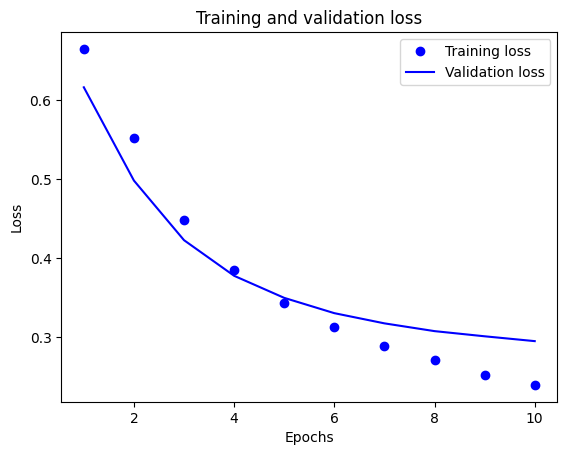

In [56]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

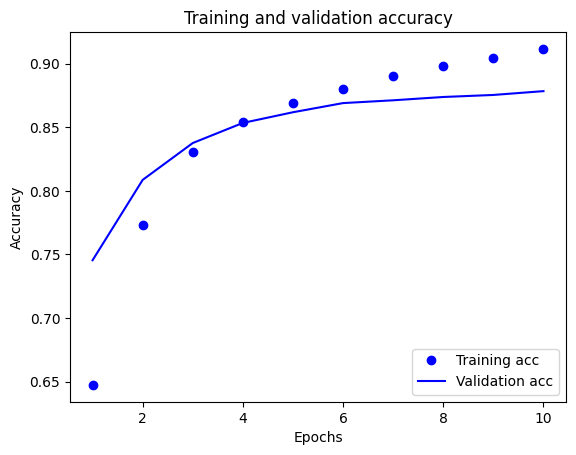

In [57]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [58]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5008 - loss: 0.5895
{'accuracy': 0.5, 'loss': 0.590340793132782}


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [59]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


array([[0.6576541 ],
       [0.6150184 ],
       [0.59250283]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python.

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier.

## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, check out the [Text classification guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
